In [44]:
import sys
sys.path.append("../")

from models.GRDPG_GD_Unroll_shared_normalized import gLASE
import torch 
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from models.RDPG_GD import GRDPG_GD_fixstep, GRDPG_GD_Armijo

# Testing model algorithms

In [2]:
device ='cpu'

d=2 
num_nodes = 100

n = [50, 50]
p = [
     [0.3, 0.9],
     [0.9, 0.3]
]
edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
M = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

Q=torch.Tensor([[1,0],[0,-1]])

x = torch.rand((num_nodes, d)).to(device)

## Gradient descent fix step

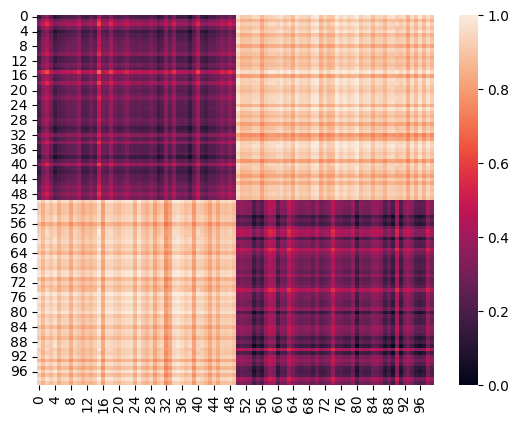

In [3]:
x_gd, cost, k = RDPG_GD_fixstep(x, edge_index, Q, M, max_iter=100, alpha=0.001)

sns.heatmap(x_gd@Q@x_gd.T, vmin=0.0, vmax=1.0, cbar=True)
plt.show()

## GLASE shared weights

Parameter containing:
tensor([[ 1., -1.]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])


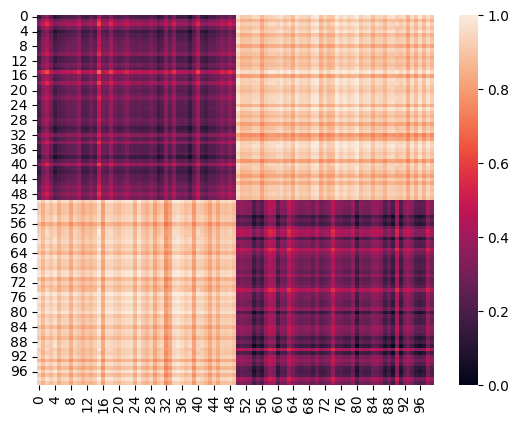

In [4]:
gd_steps = 100
model = gLASE(d,d, gd_steps)
model.to(device)

### Initialization
model.gd.lin1.weight.data = 4*0.001*torch.eye(d).to(device)
model.gd.lin2.weight.data = 4*0.001*torch.eye(d).to(device)
model.gd.lin1.weight.requires_grad = False
model.gd.lin2.weight.requires_grad = False
model.gd.Q.data = torch.Tensor([[1,-1]]).to(device)
model.gd.Q.requires_grad = False


for param in model.parameters():
    print(param)

x_glase_ = model(x, edge_index, edge_index_2)
x_glase_=x_glase_.detach().to('cpu')

sns.heatmap(x_glase_@Q@x_glase_.T, vmin=0.0, vmax=1.0, cbar=True)
plt.show()

## GLASE unshared weights

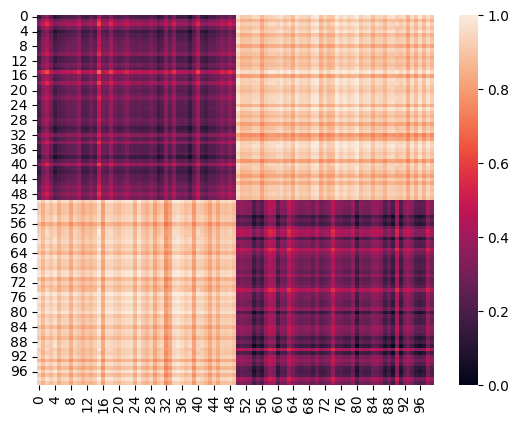

In [5]:
from models.GRDPG_GD_Unroll_unshared_normalized import gLASE as gLASE_w

gd_steps = 100
model = gLASE_w(d,d, gd_steps)
model.to(device)

n = 100
p_1 = (M.shape[1]) / n**2
p_2 = (edge_index_2.shape[1]) / n**2
        

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = 4*0.001*torch.eye(d).to(device) * (n*p_1)
    model.gd[step].lin2.weight.data = 4*0.001*torch.eye(d).to(device) * (n*p_2)
    model.gd[step].lin1.weight.requires_grad = False
    model.gd[step].lin2.weight.requires_grad = False
    

x_glase_ = model(x, edge_index, edge_index_2, Q, M)
x_glase_ = x_glase_.detach().to('cpu')

sns.heatmap(x_glase_@Q@x_glase_.T, vmin=0.0, vmax=1.0, cbar=True)
plt.show()


# Phase 1 - SBM 2

In [14]:
num_nodes = 120

n = [90, 30]

p = [
     [0.3, 0.8],
     [0.8, 0.6]
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
M = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

In [32]:
# Model 

gd_steps = 100
model1 = gLASE(d,d, gd_steps)
model1.to(device)

model2 = gLASE(d,d, gd_steps)
model2.to(device)

q1 = torch.Tensor([[1,1]])
q2 = torch.Tensor([[1,-1]])
Q1=torch.diag(q1[0])
Q2=torch.diag(q2[0])

### Initialization
model1.gd.lin1.weight.data = 4*0.001*torch.eye(d).to(device)
model1.gd.lin2.weight.data = 4*0.001*torch.eye(d).to(device)
model1.gd.lin1.weight.requires_grad = False
model1.gd.lin2.weight.requires_grad = False
model1.gd.Q.data = q1.to(device)
model1.gd.Q.requires_grad = False

model2.gd.lin1.weight.data = 4*0.001*torch.eye(d).to(device)
model2.gd.lin2.weight.data = 4*0.001*torch.eye(d).to(device)
model2.gd.lin1.weight.requires_grad = False
model2.gd.lin2.weight.requires_grad = False
model2.gd.Q.data = q2.to(device)
model2.gd.Q.requires_grad = False

for param in model1.parameters():
    print(param)

for param in model2.parameters():
    print(param)

Parameter containing:
tensor([[1., 1.]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[ 1., -1.]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])


In [33]:
k = 0
for i in range(50):
    x = torch.rand((num_nodes, d)).to(device) 
    x_glase1 = model1(x, edge_index, edge_index_2)
    x_glase2 = model2(x, edge_index, edge_index_2)
    loss1= torch.norm((x_glase1@Q1@x_glase1.T - to_dense_adj(edge_index).squeeze(0)))
    loss2= torch.norm((x_glase2@Q2@x_glase2.T - to_dense_adj(edge_index).squeeze(0)))

    if loss1 > loss2:
        k+=1
        print(q2, loss2)
    else:
        print(q1, loss1)

print("Accuracy: ", k/50)

tensor([[ 1., -1.]]) tensor(52.0466)
tensor([[ 1., -1.]]) tensor(52.0460)
tensor([[ 1., -1.]]) tensor(52.0446)
tensor([[ 1., -1.]]) tensor(52.0450)
tensor([[ 1., -1.]]) tensor(52.0451)
tensor([[ 1., -1.]]) tensor(52.0450)
tensor([[ 1., -1.]]) tensor(52.0464)
tensor([[ 1., -1.]]) tensor(52.0447)
tensor([[ 1., -1.]]) tensor(52.0456)
tensor([[ 1., -1.]]) tensor(52.0447)
tensor([[ 1., -1.]]) tensor(52.0447)
tensor([[ 1., -1.]]) tensor(52.0457)
tensor([[ 1., -1.]]) tensor(52.0448)
tensor([[ 1., -1.]]) tensor(52.0451)
tensor([[ 1., -1.]]) tensor(52.0454)
tensor([[ 1., -1.]]) tensor(52.0458)
tensor([[ 1., -1.]]) tensor(52.0445)
tensor([[ 1., -1.]]) tensor(52.0464)
tensor([[ 1., -1.]]) tensor(52.0465)
tensor([[ 1., -1.]]) tensor(52.0484)
tensor([[ 1., -1.]]) tensor(52.0461)
tensor([[ 1., -1.]]) tensor(52.0449)
tensor([[ 1., -1.]]) tensor(52.0449)
tensor([[ 1., -1.]]) tensor(52.0463)
tensor([[ 1., -1.]]) tensor(52.0449)
tensor([[ 1., -1.]]) tensor(52.0464)
tensor([[ 1., -1.]]) tensor(52.0455)
t

# Phase 1 - subgraphs

In [24]:
## validation data 
TRAIN_DATA_FILE = '../training/data/sbm2_train_subgraphs_negative_095_unbalanced.pkl'

with open(TRAIN_DATA_FILE, 'rb') as f:
    df_train = pickle.load(f)

samples = df_train[:50]

In [34]:
# Model 

gd_steps = 100
model1 = gLASE(d,d, gd_steps)
model1.to(device)

model2 = gLASE(d,d, gd_steps)
model2.to(device)

q1 = torch.Tensor([[1,1]])
q2 = torch.Tensor([[1,-1]])
Q1=torch.diag(q1[0])
Q2=torch.diag(q2[0])

### Initialization
model1.gd.lin1.weight.data = 4*0.001*torch.eye(d).to(device)
model1.gd.lin2.weight.data = 4*0.001*torch.eye(d).to(device)
model1.gd.lin1.weight.requires_grad = False
model1.gd.lin2.weight.requires_grad = False
model1.gd.Q.data = q1.to(device)
model1.gd.Q.requires_grad = False

model2.gd.lin1.weight.data = 4*0.001*torch.eye(d).to(device)
model2.gd.lin2.weight.data = 4*0.001*torch.eye(d).to(device)
model2.gd.lin1.weight.requires_grad = False
model2.gd.lin2.weight.requires_grad = False
model2.gd.Q.data = q2.to(device)
model2.gd.Q.requires_grad = False

for param in model1.parameters():
    print(param)

for param in model2.parameters():
    print(param)


Parameter containing:
tensor([[1., 1.]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[ 1., -1.]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])
Parameter containing:
tensor([[0.0040, 0.0000],
        [0.0000, 0.0040]])


In [31]:
k = 0
for sample in samples:
    x = torch.rand((sample.num_nodes, d)).to(device) 
    x_glase1 = model1(x, sample.edge_index, sample.edge_index_2)
    x_glase2 = model2(x, sample.edge_index, sample.edge_index_2)
    loss1= torch.norm((x_glase1@Q1@x_glase1.T - to_dense_adj(sample.edge_index).squeeze(0)))
    loss2= torch.norm((x_glase2@Q2@x_glase2.T - to_dense_adj(sample.edge_index).squeeze(0)))

    if loss1 > loss2:
        k+=1
        print(q2, loss2)
    else:
        print(q1, loss1)

print("Accuracy: ", k/len(samples))

tensor([[1., 1.]]) tensor(282.3193)
tensor([[1., 1.]]) tensor(310.0247)
tensor([[ 1., -1.]]) tensor(267.7607)
tensor([[1., 1.]]) tensor(342.7048)
tensor([[ 1., -1.]]) tensor(294.0905)
tensor([[ 1., -1.]]) tensor(287.5272)
tensor([[ 1., -1.]]) tensor(282.5739)
tensor([[ 1., -1.]]) tensor(282.4869)
tensor([[ 1., -1.]]) tensor(283.5086)
tensor([[1., 1.]]) tensor(281.5787)
tensor([[ 1., -1.]]) tensor(284.4550)
tensor([[ 1., -1.]]) tensor(268.0676)
tensor([[ 1., -1.]]) tensor(285.4255)
tensor([[ 1., -1.]]) tensor(307.7800)
tensor([[ 1., -1.]]) tensor(272.4877)
tensor([[1., 1.]]) tensor(310.9118)
tensor([[ 1., -1.]]) tensor(291.1741)
tensor([[ 1., -1.]]) tensor(281.6592)
tensor([[ 1., -1.]]) tensor(268.4306)
tensor([[ 1., -1.]]) tensor(266.0801)
tensor([[1., 1.]]) tensor(290.3636)
tensor([[ 1., -1.]]) tensor(255.0726)
tensor([[ 1., -1.]]) tensor(283.9823)
tensor([[ 1., -1.]]) tensor(294.7970)
tensor([[ 1., -1.]]) tensor(266.8936)
tensor([[1., 1.]]) tensor(284.3619)
tensor([[ 1., -1.]]) tenso

### Picking larger sample

In [41]:
# Model 

gd_steps = 100
model1 = gLASE(d,d, gd_steps)
model1.to(device)

model2 = gLASE(d,d, gd_steps)
model2.to(device)

q1 = torch.Tensor([[1,1]])
q2 = torch.Tensor([[1,-1]])
Q1=torch.diag(q1[0])
Q2=torch.diag(q2[0])

### Initialization
model1.gd.lin1.weight.data = 4*0.0001*torch.eye(d).to(device)
model1.gd.lin2.weight.data = 4*0.0001*torch.eye(d).to(device)
model1.gd.lin1.weight.requires_grad = False
model1.gd.lin2.weight.requires_grad = False
model1.gd.Q.data = q1.to(device)
model1.gd.Q.requires_grad = False

model2.gd.lin1.weight.data = 4*0.0001*torch.eye(d).to(device)
model2.gd.lin2.weight.data = 4*0.0001*torch.eye(d).to(device)
model2.gd.lin1.weight.requires_grad = False
model2.gd.lin2.weight.requires_grad = False
model2.gd.Q.data = q2.to(device)
model2.gd.Q.requires_grad = False

for param in model1.parameters():
    print(param)

for param in model2.parameters():
    print(param)


Parameter containing:
tensor([[1., 1.]])
Parameter containing:
tensor([[0.0004, 0.0000],
        [0.0000, 0.0004]])
Parameter containing:
tensor([[0.0004, 0.0000],
        [0.0000, 0.0004]])
Parameter containing:
tensor([[ 1., -1.]])
Parameter containing:
tensor([[0.0004, 0.0000],
        [0.0000, 0.0004]])
Parameter containing:
tensor([[0.0004, 0.0000],
        [0.0000, 0.0004]])


In [42]:
from torch_geometric.utils import dropout_node

num_nodes = 12000
n = [9000, 3000]

p = [
     [0.3, 0.8],
     [0.8, 0.6]
]

edge_index = stochastic_blockmodel_graph(n, p)

In [43]:
k = 0
for i in range(50):
    sub_edge_index, _, _ = dropout_node(edge_index, p=0.90)
    adj_matrix = to_dense_adj(sub_edge_index).squeeze(0)
    non_zero_rows = (adj_matrix.sum(dim=1) != 0)
    adj_matrix = adj_matrix[non_zero_rows]
    adj_matrix = adj_matrix[:, non_zero_rows]
    sub_edge_index = adj_matrix.nonzero().t().contiguous()  
    n_nodes = adj_matrix.shape[0]
    sub_edge_index_2 = torch.ones([n_nodes,n_nodes],).nonzero().t().contiguous()

    x = torch.rand((n_nodes, d)).to(device) 
    x_glase1 = model1(x, sub_edge_index, sub_edge_index_2)
    x_glase2 = model2(x, sub_edge_index, sub_edge_index_2)
    loss1= torch.norm((x_glase1@Q1@x_glase1.T - to_dense_adj(sub_edge_index).squeeze(0)))
    loss2= torch.norm((x_glase2@Q2@x_glase2.T - to_dense_adj(sub_edge_index).squeeze(0)))

    if loss1 >= loss2:
        k+=1
        print(q2, loss2)
    else:
        print(q1, loss1)

print("Accuracy: ", k/50)

tensor([[ 1., -1.]]) tensor(518.4415)
tensor([[ 1., -1.]]) tensor(514.3411)
tensor([[ 1., -1.]]) tensor(526.0399)
tensor([[ 1., -1.]]) tensor(564.1667)
tensor([[ 1., -1.]]) tensor(508.7096)
tensor([[ 1., -1.]]) tensor(521.4930)
tensor([[ 1., -1.]]) tensor(513.9931)
tensor([[ 1., -1.]]) tensor(505.8214)
tensor([[ 1., -1.]]) tensor(513.7350)
tensor([[ 1., -1.]]) tensor(534.6782)
tensor([[ 1., -1.]]) tensor(495.4078)
tensor([[ 1., -1.]]) tensor(515.5259)
tensor([[ 1., -1.]]) tensor(515.7147)
tensor([[ 1., -1.]]) tensor(515.0050)
tensor([[ 1., -1.]]) tensor(536.8835)
tensor([[ 1., -1.]]) tensor(494.8168)
tensor([[ 1., -1.]]) tensor(538.9543)
tensor([[ 1., -1.]]) tensor(526.6065)
tensor([[ 1., -1.]]) tensor(534.2908)
tensor([[ 1., -1.]]) tensor(516.4105)
tensor([[ 1., -1.]]) tensor(500.8866)
tensor([[ 1., -1.]]) tensor(532.7646)
tensor([[ 1., -1.]]) tensor(534.3158)
tensor([[ 1., -1.]]) tensor(524.7447)
tensor([[ 1., -1.]]) tensor(530.9207)
tensor([[ 1., -1.]]) tensor(511.6057)
tensor([[ 1.

# Phase 1 - SBM 3

In [30]:
np.linalg.eig(np.array(p))

(array([ 2.07826069, -0.46325476, -0.21500593]),
 array([[-0.63044619, -0.62341611, -0.46248238],
        [-0.53897073,  0.78033365, -0.31715917],
        [-0.5586127 , -0.04931267,  0.82796142]]))

In [64]:
device = 'cuda'
d = 3
num_nodes = 300

n = [150, 90, 60]

p = [
     [0.6, 0.9, 0.8],
     [0.9, 0.3, 0.7],
     [0.8, 0.7, 0.5]
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
M = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

q1 = torch.Tensor([[1,1,1]])
q2 = torch.Tensor([[1,1,-1]])
q3 = torch.Tensor([[1,-1,-1]])
Q1=torch.diag(q1[0]).to(device)
Q2=torch.diag(q2[0]).to(device)
Q3=torch.diag(q3[0]).to(device)

x = torch.rand((num_nodes, d)).to(device) 

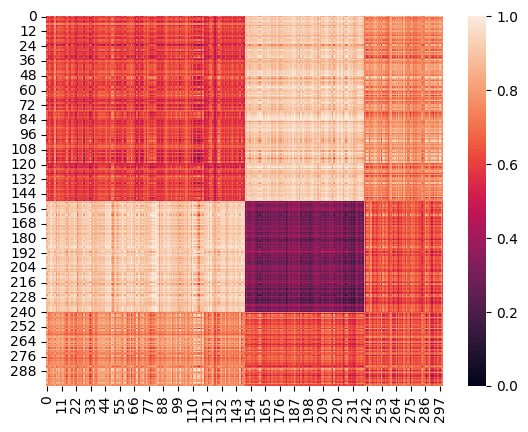

In [65]:
x_gd, cost, k = GRDPG_GD_Armijo(x, edge_index, Q3, M)
x_gd=x_gd.to('cpu')

sns.heatmap(x_gd@Q3.to('cpu')@x_gd.T, vmin=0.0, vmax=1.0, cbar=True)
plt.show()

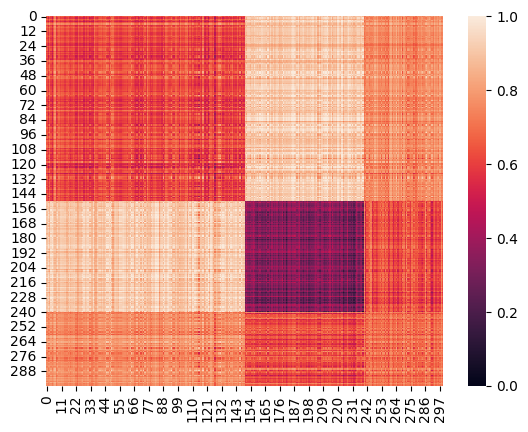

In [68]:
## Ground truth

x_gd, cost, k = GRDPG_GD_fixstep(x, edge_index, Q3, M, max_iter=300, alpha=0.0001)
x_gd=x_gd.to('cpu')

sns.heatmap(x_gd@Q3.to('cpu')@x_gd.T, vmin=0.0, vmax=1.0, cbar=True)
plt.show()

In [69]:
# Model 

gd_steps = 300
model1 = gLASE(d,d, gd_steps)
model1.to(device)

model2 = gLASE(d,d, gd_steps)
model2.to(device)

model3 = gLASE(d,d, gd_steps)
model3.to(device)

### Initialization
model1.gd.lin1.weight.data = 4*0.0001*torch.eye(d).to(device)
model1.gd.lin2.weight.data = 4*0.0001*torch.eye(d).to(device)
model1.gd.lin1.weight.requires_grad = False
model1.gd.lin2.weight.requires_grad = False
model1.gd.Q.data = q1.to(device)
model1.gd.Q.requires_grad = False

model2.gd.lin1.weight.data = 4*0.0001*torch.eye(d).to(device)
model2.gd.lin2.weight.data = 4*0.0001*torch.eye(d).to(device)
model2.gd.lin1.weight.requires_grad = False
model2.gd.lin2.weight.requires_grad = False
model2.gd.Q.data = q2.to(device)
model2.gd.Q.requires_grad = False

model3.gd.lin1.weight.data = 4*0.0001*torch.eye(d).to(device)
model3.gd.lin2.weight.data = 4*0.0001*torch.eye(d).to(device)
model3.gd.lin1.weight.requires_grad = False
model3.gd.lin2.weight.requires_grad = False
model3.gd.Q.data = q3.to(device)
model3.gd.Q.requires_grad = False

count_model_1 = 0
count_model_2 = 0
count_model_3 = 0

for i in range(50):
    x = torch.rand((num_nodes, d)).to(device) 
    x_glase1 = model1(x, edge_index, edge_index_2)
    x_glase2 = model2(x, edge_index, edge_index_2)
    x_glase3 = model3(x, edge_index, edge_index_2)
    loss1= torch.norm((x_glase1@Q1@x_glase1.T - to_dense_adj(edge_index).squeeze(0)))
    loss2= torch.norm((x_glase2@Q2@x_glase2.T - to_dense_adj(edge_index).squeeze(0)))
    loss3= torch.norm((x_glase3@Q3@x_glase3.T - to_dense_adj(edge_index).squeeze(0)))
    
    arr_loss = np.array([loss1.detach().to('cpu').numpy(), loss2.detach().to('cpu').numpy(), loss3.detach().to('cpu').numpy()])
    print(arr_loss)
    if np.argmin(arr_loss) == 0:
        count_model_1+=1
    elif np.argmin(arr_loss) == 1:
        count_model_2+=1
    else:
        count_model_3+=1
        
arr_count = np.array([count_model_1, count_model_2, count_model_3])
print(arr_count)
        
if np.argmin(arr_count) == 0:
    Q = Q1
elif np.argmin(arr_count) == 1:
    Q = Q2
else:
    Q = Q3

[134.95372  134.97157  124.894554]
[134.98148  124.93983  124.759186]
[135.0418  134.09825 125.30747]
[135.01117  126.26421  125.420906]
[134.90555 124.94637 124.80524]
[134.98198 124.92901 124.78934]
[134.97253  126.06519  124.791534]
[134.94762 125.1049  124.85073]
[134.94633 124.88627 124.7522 ]
[135.0258  134.84761 124.85096]
[134.921   128.05496 127.00618]
[134.9358  124.72674 124.69997]
[135.03242 126.1941  125.05572]
[134.92064 127.39861 124.77138]
[134.92632 126.16779 124.79476]
[134.908    124.872696 124.676575]
[135.04372 134.9716  124.78   ]
[135.00381 125.78499 124.68903]
[135.03947 124.82041 124.65838]
[134.97444  125.215904 124.73717 ]
[134.93059 126.72118 124.73244]
[134.97118  125.289215 124.97849 ]
[134.92468 132.32703 124.70139]
[134.98415  125.14637  124.828545]
[135.0399  124.85587 124.67623]
[135.0324  125.42061 124.87877]
[135.04134 125.15242 124.84795]
[134.9467  130.17166 127.54675]
[134.94806  124.964615 124.74682 ]
[134.98074 126.04678 124.73433]
[134.98596  1